# Notebook to explore the universe of alternative alphabets

Goal is to write a poem that will allow complementary base pairing: i.e. the key and query of a dictionary can be flipped and still allow for a valid sentence.

In [17]:
import numpy as np
import pandas as pd
import string
import os
import shutil
import plotnine
from plotnine import *
from timeit import timeit
import string

from math import factorial
import itertools

from funs import makeifnot
from funs import rand_mapping, alpha_trans

letters = [l for l in string.ascii_lowercase]


In [2]:
# There are >51 billion possible alphabet encodings
print(f"{np.prod(np.arange(2,27,2)):,}")

51,011,754,393,600


In [3]:
# print(f"{:,}")
# np.prod(np.arange(1,27,1))

### (1) Download datasets

In [4]:
dir_code = os.getcwd()
dir_data = os.path.join(dir_code, '..', 'data')
makeifnot(dir_data)
# (1) Download the ngrams data for frequency
path_ngram = os.path.join(dir_data,'words_ngram.txt')
if not os.path.exists(path_ngram):
    !wget -q -O ../data/words_ngram.txt https://norvig.com/ngrams/count_1w.txt
else:
    print('words_ngram.txt already exists')

# (2) Download the curated dataset
path_words = os.path.join(dir_data,'words_corncob.txt')
if not os.path.exists(path_words):
    print('Downloading')
    !wget -q -O ../data/words_corncob.txt http://www.mieliestronk.com/corncob_lowercase.txt
else:
    print('corncob_lowercase.txt already exists')
#https://github.com/dwyl/english-words

words_ngram.txt already exists
corncob_lowercase.txt already exists


## (2) Load datasets

In [5]:
# (1) Load the Ngrams
df_ngram = pd.read_csv(path_ngram,sep='\t',header=None).rename(columns={0:'word',1:'n'})
df_ngram = df_ngram[~df_ngram.word.isnull()].reset_index(None, True)

# (2) Load the short word set
df_words = pd.read_csv(path_words,sep='\n',header=None).rename(columns={0:'word'})
df_words = df_words[~df_words.word.isnull()].reset_index(None, True)

# Overlap?
n_overlap = df_words.word.isin(df_ngram.word).sum()
print('A total of %i short words overlap (out of %i)' % 
     (n_overlap, df_words.shape[0]))

# Merge datasets in the intersection
df_merge = df_ngram.merge(df_words,'inner','word')
df_merge = df_merge.assign(n_sqrt=lambda x: np.sqrt(x.n), n_log=lambda x: np.log(x.n))

# Examine the score frequency by percentiles
p_seq = np.arange(0.01,1,0.01)
dat_n_q = df_merge.melt('word',None,'tt').groupby('tt').value.quantile(p_seq).reset_index()
dat_n_q.rename(columns={'level_1':'qq'}, inplace=True)
dat_n_q.tt = pd.Categorical(dat_n_q.tt,['n','n_sqrt','n_log'])
di_tt = {'n':'n', 'n_sqrt':'sqrt','n_log':'log'}

A total of 51886 short words overlap (out of 58109)


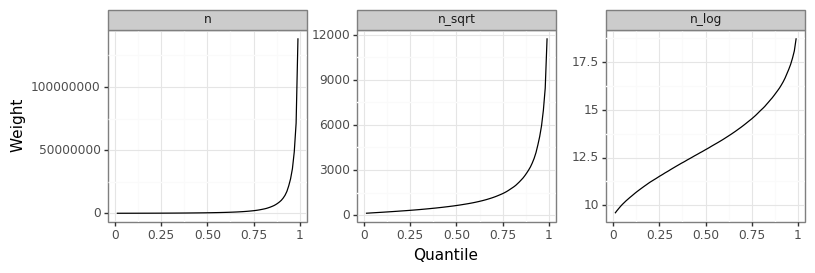

<ggplot: (8748885130873)>

In [6]:
# DISTIRUBTION OF WORD FREQUENCIES
plotnine.options.figure_size = (9, 2.5)
gg_q = (ggplot(dat_n_q, aes(x='qq',y='value')) + geom_path() + 
       theme_bw() + facet_wrap('~tt',scales='free_y') + 
       labs(y='Weight', x='Quantile') + 
       theme(subplots_adjust={'wspace': 0.25}))
gg_q

In [7]:
print('The ten most and least common words in the corpus')
pd.concat([df_merge.head(10)[['word','n']].reset_index(None,True),
           df_merge.tail(10)[['word','n']].reset_index(None,True)],1)

The ten most and least common words in the corpus


,word,n,word,n
0,the,23135851162,offcuts,12748
1,of,13151942776,hinderer,12737
2,and,12997637966,eminences,12734
3,to,12136980858,vaporisation,12732
4,in,8469404971,expurgated,12732
5,for,5933321709,concussed,12732
6,is,4705743816,griever,12729
7,on,3750423199,sibilance,12720
8,that,3400031103,synchronises,12719
9,by,3350048871,insatiably,12717


### (3) Create mappings

In [8]:
num_letters = np.arange(1,27)
di_num2let = dict(zip(num_letters, letters))
nletters = 26
Xmap = rand_mapping(1,letters, nletters)
di_map = dict(zip(Xmap[:,0], Xmap[:,1]))
rwords = df_merge.word.sample(3,random_state=1)
print(pd.DataFrame({'words':rwords, 'mapped':alpha_trans(rwords, Xmap).values}))
print('Mapping: %s' % (','.join(pd.DataFrame(Xmap).apply(lambda x: x.str.cat(sep=':'),1).to_list())))

         words   mapped
43284  scarcer  neqdecd
7314   adaptor  qrqzuhd
7460   distant  rmnuqsu
Mapping: s:n,r:d,w:k,t:u,e:c,v:g,o:h,x:b,q:a,p:z,y:j,i:m,l:f


In [125]:
def rand_cipher(seed,lst):
    np.random.seed(seed)
    holder = []
    holder2 = []
    j = 0
    for i in list(range(len(lst)-1,0,-2)):
        l1 = lst[0]
        q = np.random.randint(1,i+1)
        l2 = lst[q]
        lst.remove(l1)
        lst.remove(l2)
        holder.append(l1 + ':' + l2)
        if j == 0:
            holder2.append(q)
        j += 1
    return holder
    
pd.Series(np.array([rand_cipher(seed=i,lst=letters[0:4].copy()) for i in range(100000)]).flatten()).value_counts(True)

c:d    0.166935
a:b    0.166935
a:c    0.166810
b:d    0.166810
a:d    0.166255
b:c    0.166255
dtype: float64

In [141]:
def get_cipher(idx,lst):
    holder = []
    holder2 = []
    assert idx + 1 <= np.prod(np.arange(1,len(lst),2))
    j = 0
    for i in list(range(len(lst)-1,0,-2)):
        l1 = lst[0]
        q = (idx % i) + 1
        l2 = lst[q]
        lst.remove(l1)
        lst.remove(l2)
        holder.append(l1 + ':' + l2)
        if j == 0:
            holder2.append(q)
        j += 1
    return holder
    
#pd.Series(np.array().flatten()).value_counts(True)
pd.DataFrame([get_cipher(idx=i,lst=letters[0:6].copy()) for i in range(15)])

,0,1,2
0,a:b,c:d,e:f
1,a:c,b:e,d:f
2,a:d,b:f,c:e
3,a:e,b:c,d:f
4,a:f,b:d,c:e
5,a:b,c:f,d:e
6,a:c,b:d,e:f
7,a:d,b:e,c:f
8,a:e,b:f,c:d
9,a:f,b:c,d:e


In [9]:
def forwardPerm(idx, lst):
    alst = lst.copy()  # Active copy
    holder = []  # Store the list combination and index
    for j in range(len(lst)):
        if len(alst) == 1:  # Terminate when there is one element less
            q = 0
            v = alst[q]
            holder.append([v, q])
            break
        else:
            nperm = factorial(len(alst)-1)
            q, r = divmod(idx, nperm)
            v = alst[q]
            alst.remove(v)  # Remove v from the list
            idx = r
            holder.append([v, q])
    return holder


dat = pd.concat([pd.DataFrame(forwardPerm(i,letters[0:4])).assign(idx=i) for i in range(24)])
dat.rename(columns={0:'letter', 1:'q'},inplace=True)
dat.groupby(['letter','q']).size().reset_index().rename(columns={0:'n'}).head(3)

,letter,q,n
0,a,0,24
1,b,0,12
2,b,1,12


In [10]:
# txt = words.sample(13,random_state=1).copy()
# trans = alpha_trans(txt, Xmap)
# df_example = pd.concat([pd.DataFrame(Xmap,columns=['from','to']),
#                         pd.DataFrame({'original':txt, 'mapped':trans}).reset_index(None,True)],1)
# print(df_example)  #[['from','to']]

In [11]:
# from time import time

# nsim = 80000
# tnow = time()

# holder = []
# for ii in range(nsim):
#     if (ii+1) % 10000 == 0:
#         tdiff = time() - tnow
#         print('Simulation %i of %i (took %i seconds)' % (ii+1, nsim, tdiff))
#         tnow = time()
#     # Generate a random mapping
#     Xmap = gen_mapping(ii, letters, nletters)
#     words = words[words.notnull()].reset_index(None,True)
#     trans = alpha_trans(words.copy(), Xmap)
#     idx = trans.isin(words)
#     df = pd.DataFrame({'original':words[idx],'mapped':trans[idx],'seed':ii})
#     holder.append(df)
# dat_sim = pd.concat(holder).reset_index(None,True)